In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [7]:
img1 = cv.imread('./imageFolder/Field/1.jpg')
img2 = cv.imread('./imageFolder/Field/2.jpg')

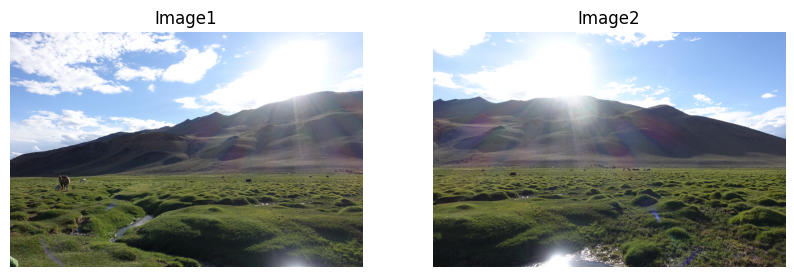

In [14]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(img1,cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Image1')


plt.subplot(1,2,2)
plt.imshow(cv.cvtColor(img2,cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Image2')
plt.show()

In [15]:
gray1 = cv.cvtColor(img1,cv.COLOR_BGR2GRAY)
gray2 = cv.cvtColor(img2,cv.COLOR_BGR2GRAY)

In [17]:
sift = cv.SIFT_create()


In [18]:
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

In [23]:
des1.shape

(6264, 128)

In [19]:
img1_kp= cv.drawKeypoints(img1,kp1,None,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_kp= cv.drawKeypoints(img2,kp2,None,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

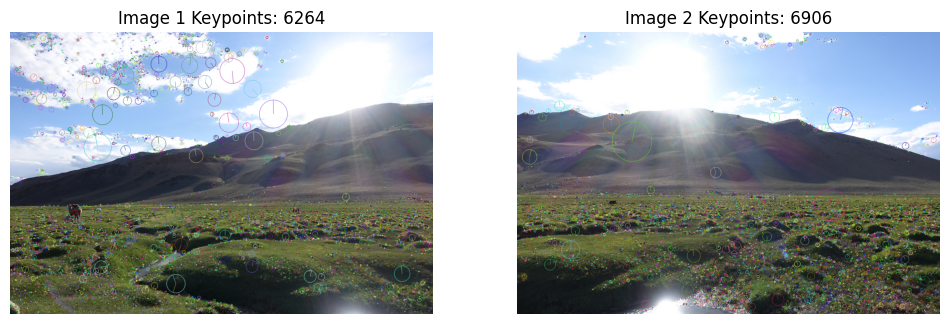

In [21]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(img1_kp, cv.COLOR_BGR2RGB))
plt.title(f"Image 1 Keypoints: {len(kp1)}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(img2_kp, cv.COLOR_BGR2RGB))
plt.title(f"Image 2 Keypoints: {len(kp2)}")
plt.axis('off')

plt.show()

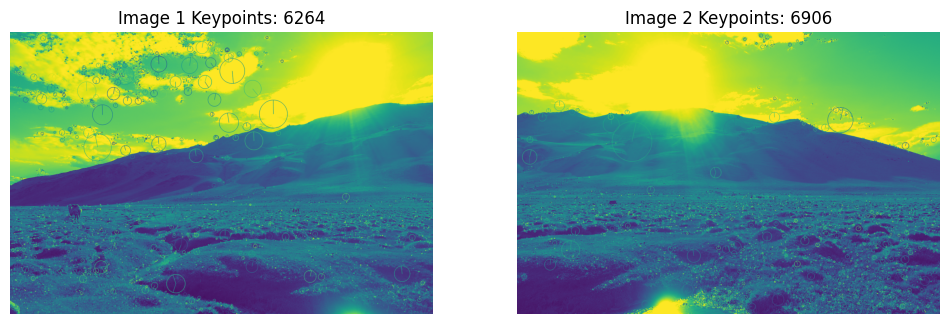

In [22]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(img1_kp, cv.COLOR_BGR2GRAY))
plt.title(f"Image 1 Keypoints: {len(kp1)}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(img2_kp, cv.COLOR_BGR2GRAY))
plt.title(f"Image 2 Keypoints: {len(kp2)}")
plt.axis('off')

plt.show()

In [24]:
bf = cv.BFMatcher()

In [25]:
matches = bf.knnMatch(des1,des2,k=2)

In [26]:
good_matches = []

for m,n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append([m])

print(f"Total_matches is {len(matches)}")  
print(f"Total good matches is {len(good_matches)}")

Total_matches is 6264
Total good matches is 963


In [27]:
img_matches = cv.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, None, flags=2)

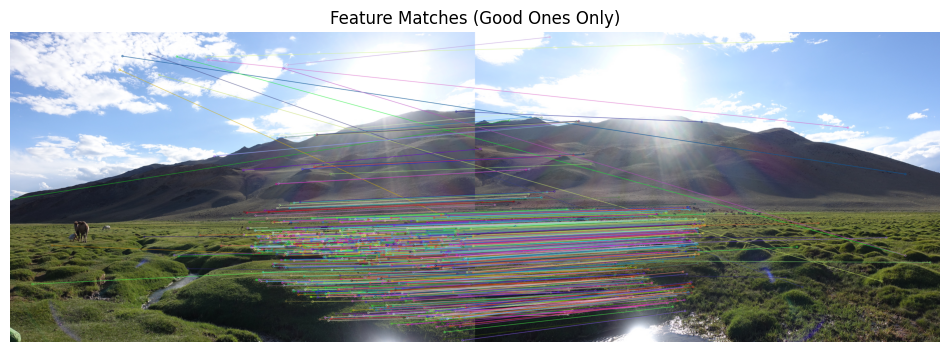

In [29]:
plt.figure(figsize=(12,8))
plt.imshow(cv.cvtColor(img_matches,cv.COLOR_BGR2RGB))
plt.title("Feature Matches (Good Ones Only)")
plt.axis('off')
plt.show()

In [30]:
pts_img1 =[]
pts_img2 = []

for match in good_matches:
    m = match[0]
    pts_img1.append(kp1[m.queryIdx].pt)
    pts_img2.append(kp2[m.trainIdx].pt)
    
pts_img1= np.float32(pts_img1)    
pts_img2= np.float32(pts_img2)    

In [31]:
H,mask = cv.findHomography(pts_img1,pts_img2,cv.RANSAC,4.0)

In [32]:
print("Homography matrix:")
print(H)
print(f"Inliers found: {np.sum(mask)} / {len(mask)}")

Homography matrix:
[[ 3.01533554e+00 -4.54049226e-01 -2.14856631e+03]
 [ 8.25986794e-01  2.32073748e+00 -9.65241250e+02]
 [ 1.28760139e-03 -1.09524637e-04  1.00000000e+00]]
Inliers found: 823 / 963


In [33]:
h1,w1 = img1.shape[:2]
h2,w2 = img2.shape[:2]

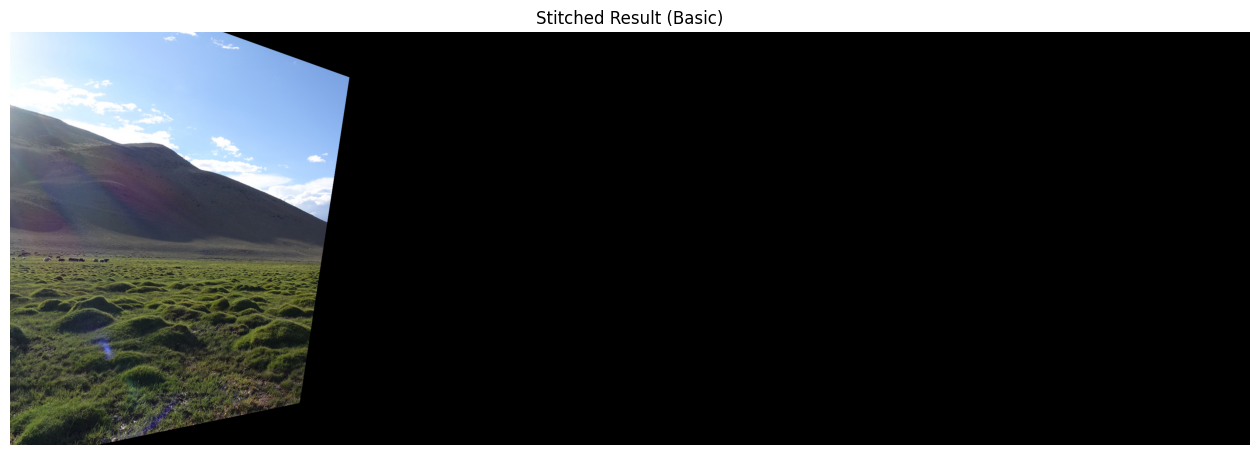

In [38]:
warped_img2 = cv.warpPerspective(img2,H,(w1+w2,max(h1,h2)))

plt.figure(figsize=(16,8))
plt.imshow(cv.cvtColor(warped_img2, cv.COLOR_BGR2RGB))
plt.title("Stitched Result (Basic)")
plt.axis('off')
plt.show()


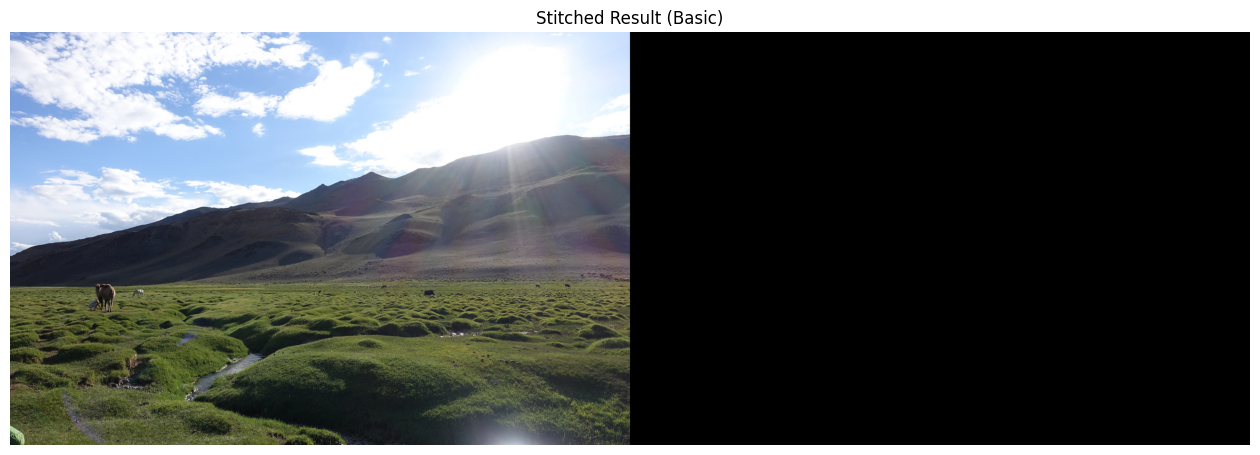

In [39]:
warped_img2 = cv.warpPerspective(img2,H,(w1+w2,max(h1,h2)))

warped_img2[0:h1,0:w1]=img1

plt.figure(figsize=(16,8))
plt.imshow(cv.cvtColor(warped_img2, cv.COLOR_BGR2RGB))
plt.title("Stitched Result (Basic)")
plt.axis('off')
plt.show()

In [44]:
def compute_new_canvas_and_update_topography(img1,img2,H):
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]

    corners_img2 = np.array([
        [0,0],
        [w2,0],
        [w2,h2],
        [0,h2]
    ],dtype='float32').reshape(-1,1,2)

    warped_corners_img2 = cv.perspectiveTransform(corners_img2,H)

    x_min,y_min = np.int32(warped_corners_img2.min(axis=0).ravel())
    x_max,y_max = np.int32(warped_corners_img2.max(axis=0).ravel())

    tx = -x_min if x_min<0 else 0
    ty = -y_min if y_min<0 else 0

    T = np.array([
        [1, 0, tx],
        [0, 1, ty],
        [0, 0, 1]
    ])


    H_updated = T @ H

    new_width = max(x_max+tx,w1+tx)
    new_height = max(y_max+ty,h1+ty)

    return H_updated, (new_width, new_height), (tx, ty)

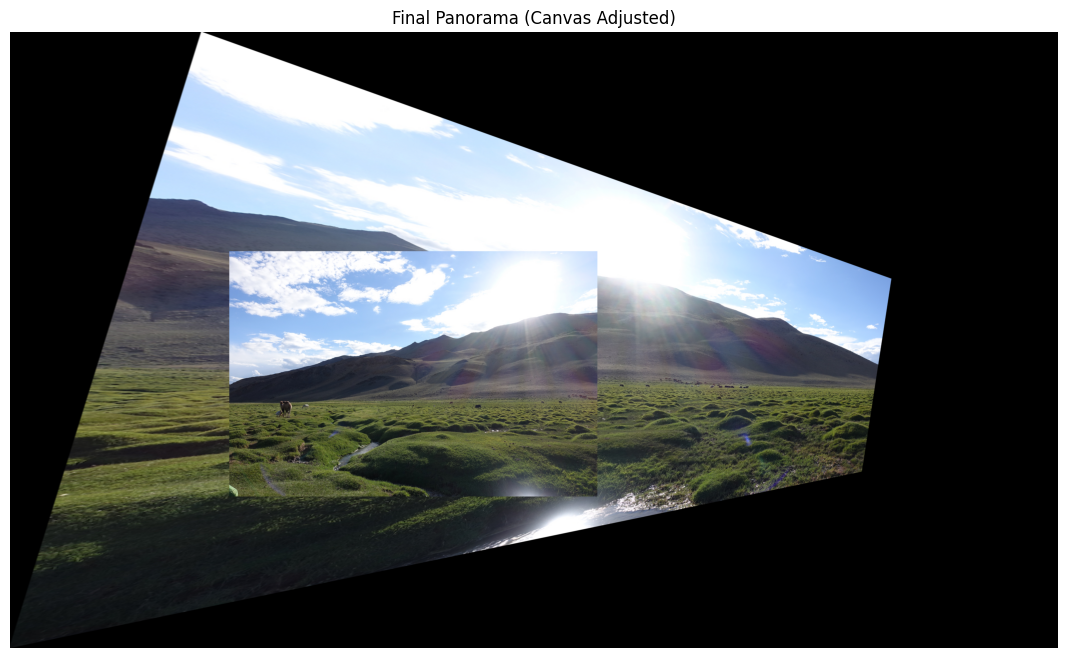

In [46]:
H_updated,(new_width,new_height),(tx,ty) = compute_new_canvas_and_update_topography(img1,img2,H)

warped_img2 = cv.warpPerspective(img2,H_updated,(new_width,new_height))

final_canvas = warped_img2.copy()

final_canvas[ty:ty+img1.shape[0],ty:ty+img1.shape[1]] = img1
plt.figure(figsize=(16, 8))
plt.imshow(cv.cvtColor(final_canvas, cv.COLOR_BGR2RGB))
plt.title("Final Panorama (Canvas Adjusted)")
plt.axis('off')
plt.show()